In [1]:
# import 
import cv2
import matplotlib.pyplot as plt
import numpy as np
import copy

In [2]:
# draw:
def plt_show(title,img,cmap = None):
    fig = plt.figure()
    plt.title(title)
    plt.imshow(img,cmap=cmap)
    plt.show()

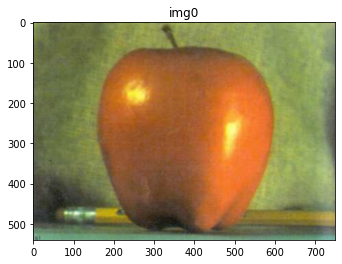

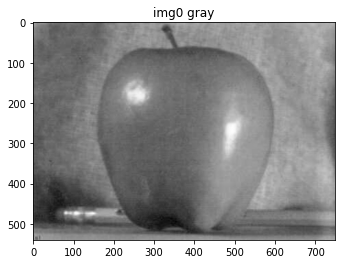

In [3]:
# load img:
img0 = cv2.imread('apple.png')
# show:
img0_gray = cv2.cvtColor(img0,cv2.COLOR_BGR2GRAY)
img0_color = cv2.cvtColor(img0,cv2.COLOR_BGR2RGB)
plt_show("img0",img0_color)
plt_show("img0 gray",img0_gray,cmap="gray")

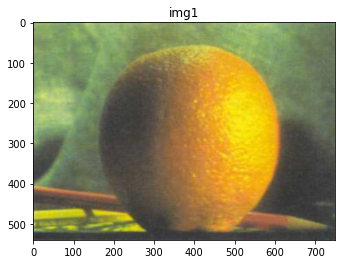

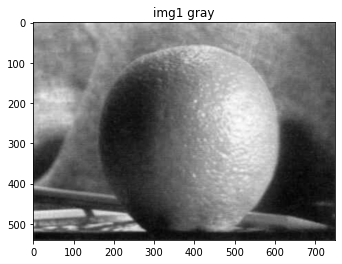

In [4]:
# load another img:
img1 = cv2.imread('orange.png')
# show:
img1_gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
img1_color = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
plt_show("img1",img1_color)
plt_show("img1 gray",img1_gray,cmap="gray")

In [5]:
# kernel & level define:
kernel = 1/16*np.array([1,4,6,4,1])
level = 4

In [6]:
# transfer int to uint:
def int2uint(number):
    if len(number.shape)>1:
        number[number<0] = 0
        number[number>255] = 255
        return number.astype('uint8')

In [7]:
# 对图像构建高斯金字塔：使用cv2.pyrDown()
def gauss_pyramid(img,level):
    gauss_pyr = []
    img_c = copy.deepcopy(img)
    # 放原图作为第零层：
    gauss_pyr.append(img_c)
    for i in range(level):
        img_c = cv2.pyrDown(img_c)
        plt_show("gauss pyr layer = {}".format(i+1),img_c,cmap="gray")
        gauss_pyr.append(img_c)
    return gauss_pyr

In [8]:
# 自己实现的卷积操作：
# conv with 1D kernel:
def conv(img,kernel,axis,fill=False):
    img_copy = copy.deepcopy(img)
    img_copy = np.array(img_copy,dtype='int')
    # need to be filled:
    if fill:
        padding = len(kernel)//2
        if axis ==0:
            img_copy = np.pad(img_copy,((padding,padding),(0,0)),'constant',constant_values = ((0,0),(0,0)))
        else:
            img_copy = np.pad(img_copy,((0,0),(padding,padding)),'constant',constant_values = ((0,0),(0,0)))
    # conv size:
    conv_length = img_copy.shape[axis]-len(kernel)+1
    conv_res = 0
    if axis==0:
        conv_res = np.zeros((conv_length,img_copy.shape[1]),dtype='uint8')
        for j in range(img_copy.shape[1]):
            for i in range(conv_length):
                temp = np.dot(img_copy[i:i+len(kernel),j],kernel).sum()
                if temp>255:
                    temp = 255
                conv_res[i][j] = temp
    else:
        conv_res = np.zeros((img_copy.shape[0],conv_length),dtype='uint8')
        for i in range(img_copy.shape[0]):
            for j in range(conv_length):
                temp = np.dot(img_copy[i,j:j+len(kernel)],kernel).sum()
                if temp>255:
                    temp = 255
                conv_res[i][j] = temp

    return conv_res

In [9]:
# 自己实现的下采样操作：
def downsample(img_conv,width,length,axis):
    img_down = np.zeros((width,length),dtype='uint8')
    index = 0
    for i in range(0,img_conv.shape[axis],2):
        if axis==0:
            if index>=width:
                break
            img_down[index,:] = img_conv[i,:]
        else:
            if index>=length:
                break
            img_down[:,index] = img_conv[:,i]
        index+=1
        
    return img_down

In [10]:
# 自己实现的高斯金字塔：
# construct Gaussian pyramid
def gauss_pyramid_pro(img,kernel,level):
    img_global = copy.deepcopy(img)
    plt_show("I0",img,cmap="gray")
    img_gaussian = []
    # put the origin mask first:
    img_gaussian.append(img)
    for i in range(level):
        # 1D kernel:
        img_conv = 0
        if len(kernel.shape)==1:
            # H(w)&downsample:
            # row
            img_conv = conv(img_global,kernel,0)
           
            img_down = downsample(img_conv,img_conv.shape[0]//2,img_conv.shape[1],0)
            # column:
            img_conv = conv(img_down,kernel,1)
            img_down = downsample(img_conv,img_conv.shape[0],img_conv.shape[1]//2,1)

            # show
            plt_show("down I"+str(i+1),img_down,cmap="gray")
            img_gaussian.append(img_down)

            # recursive
            img_global = img_down
    return img_gaussian

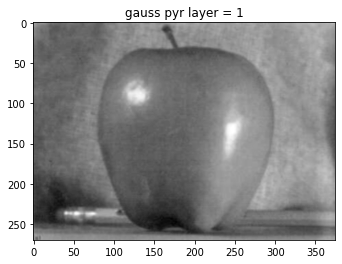

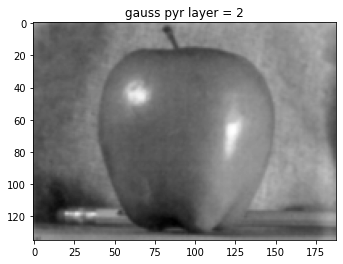

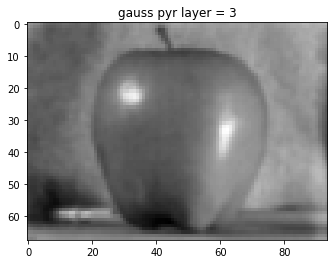

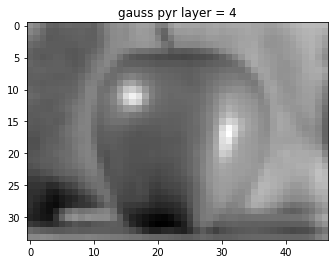

In [11]:
# 使用cv2.pyrDown()提供的卷积操作
img0_gauss_pyr = gauss_pyramid(img0_gray,level)

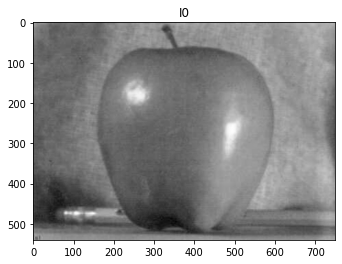

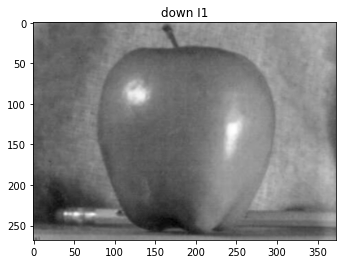

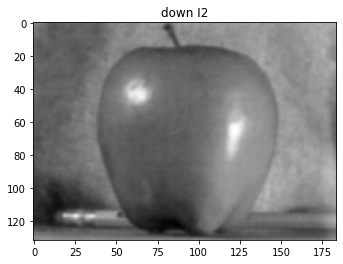

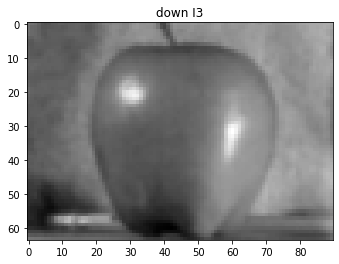

In [12]:
# 自己实现的高斯金字塔：
img0_gauss_pyr_pro = gauss_pyramid_pro(img0_gray,kernel,3)

In [13]:
# 拉普拉斯金字塔：使用cv2.pyrUp()构建：
def lap_pyramid(gauss_pyr,level):
    lap_pyr = []
    for i in range(1,level+1):
        # expand:
        temp = cv2.pyrUp(gauss_pyr[i]) 
        # substract:
        width = min(gauss_pyr[i-1].shape[0],temp.shape[0])
        length = min(gauss_pyr[i-1].shape[1],temp.shape[1])
        a = np.array(gauss_pyr[i-1][:width,:length],dtype='int')
        b = np.array(temp[:width,:length],dtype='int')
        sub = a-b
        plt_show("lap lay={}".format(i-1),sub,cmap="gray")
        lap_pyr.append(sub)
    lap_pyr.append(gauss_pyr[level])
    return lap_pyr

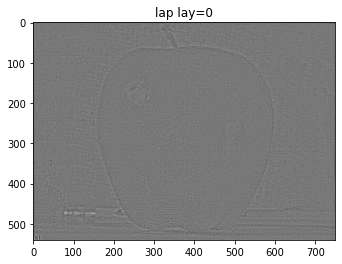

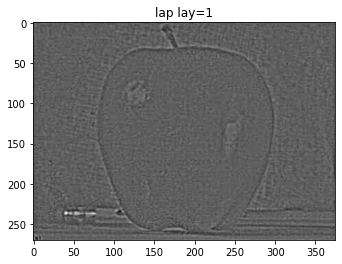

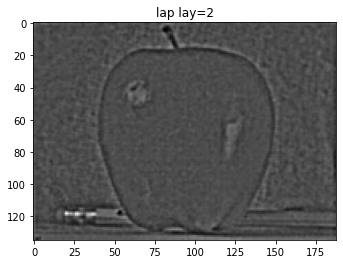

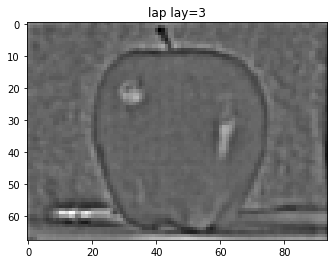

In [14]:
# 使用cv2.pyrUp()构建的拉普拉斯金字塔
img0_lap_pyr =  lap_pyramid(img0_gauss_pyr,level)

In [15]:
# 自己实现的上采样操作：
def oversample(img_down,axis):
    if axis==0:
        img_up = np.zeros((img_down.shape[0]*2,img_down.shape[1]),dtype='uint8')
        for i in range(0,img_down.shape[0]):
            img_up[i*2,:] = img_down[i,:]
            img_up[i*2+1,:] = 0
    else:
        img_up = np.zeros((img_down.shape[0],img_down.shape[1]*2),dtype='uint8')
        for i in range(0,img_down.shape[1]):
            img_up[:,i*2] = img_down[:,i]
            img_up[:,i*2+1] = 0
    return img_up

In [16]:
# 试一下自己写的lap_pyramid：
def lap_pyramid_pro(img,kernel,level):
    img_global = copy.deepcopy(img)
    plt_show("I0",img,cmap="gray")
    img_laplacian = []
    for i in range(level):
        img_level = []
        # 1D kernel:
        img_conv = 0
        if len(kernel.shape)==1:
            # H(w)&downsample:
            # row:
            img_conv = conv(img_global,kernel,0)
            img_down = downsample(img_conv,img_conv.shape[0]//2,img_conv.shape[1],0)
            # column:
            img_conv = conv(img_down,kernel,1)
            img_down = downsample(img_conv,img_conv.shape[0],img_conv.shape[1]//2,1)
            plt_show("I"+str(i+1),img_down,cmap="gray")
            img_level.append(img_down)
            

            # oversample&G(w):
            # column:
            img_up = oversample(img_down,1)
            img_conv = conv(img_up,kernel,1)
            img_conv*=2 # G(w) = H(w)*2
            # row:
            img_up = oversample(img_conv,0)
            img_conv = conv(img_up,kernel,0)
            img_conv*=2

        # b:
        # unity size:
        height = min(img_global.shape[0],img_conv.shape[0])
        length = min(img_global.shape[1],img_conv.shape[1])
        img_coff = np.array(img_global[:height,:length],dtype='int')-np.array(img_conv[:height,:length],dtype='int')
        plt_show("b"+str(i),img_coff,cmap="gray")
        img_level.append(img_coff)
        img_laplacian.append(img_level)

        # recursive:
        img_global = img_down
    return img_laplacian
    

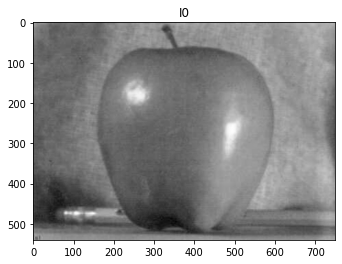

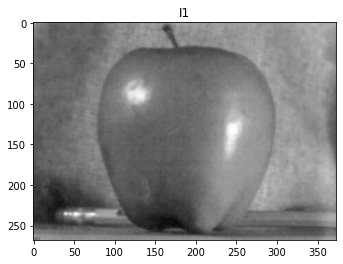

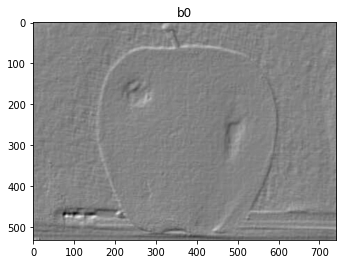

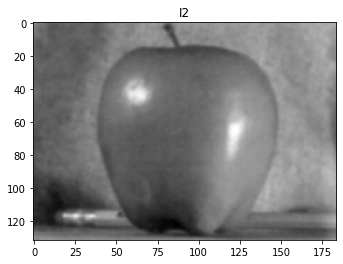

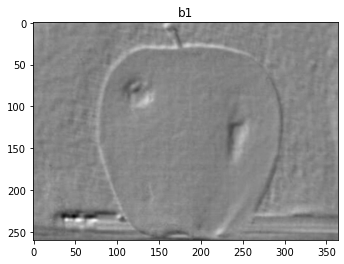

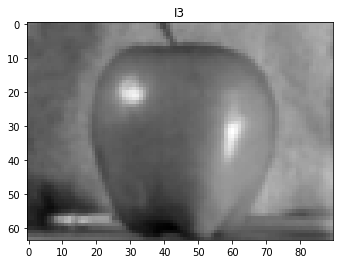

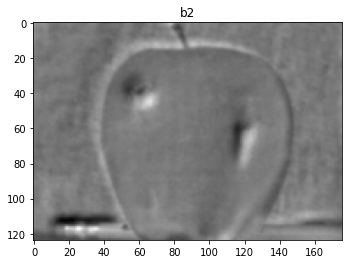

In [17]:
# 用自己实现的拉普拉斯金字塔构建：
img0_lap_pyr_pro = lap_pyramid_pro(img0_gray,kernel,3)

In [18]:
# mask:
mask0 = np.zeros((img0.shape[:2]))
mask0[:,:img0.shape[1]//2] = 1

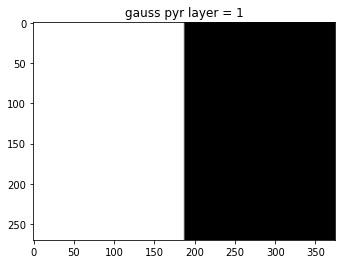

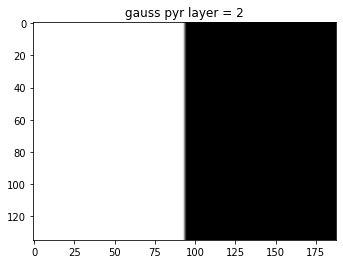

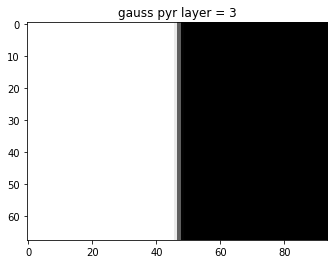

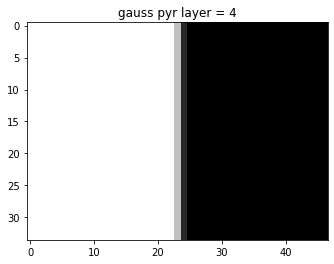

In [19]:
# 对mask构建高斯金字塔：
mask0_gauss = gauss_pyramid(mask0,level)

In [20]:
# 融合拉普拉斯金字塔和掩膜：
def blended_pyramid(lap_pyr,mask_gauss):
    blend_pyr = []
    for i in range(len(lap_pyr)):
        # fix size:
        width = min(lap_pyr[i].shape[0],mask_gauss[i].shape[0])
        length = min(lap_pyr[i].shape[1],mask_gauss[i].shape[1])
        
        a = lap_pyr[i][:width,:length]
        b = mask_gauss[i][:width,:length]
        add = int2uint(np.multiply(a,b))

        plt_show("blended pyr lay={}".format(i),add,cmap="gray")
        blend_pyr.append(add)
    return blend_pyr

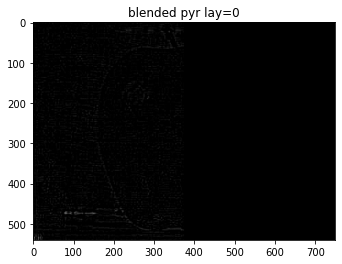

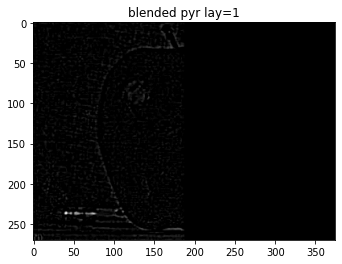

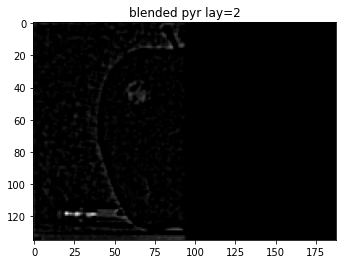

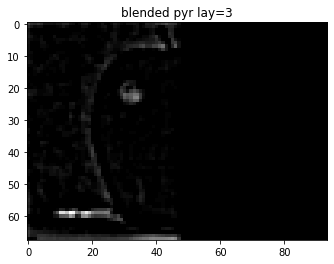

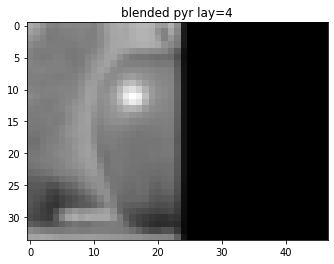

In [21]:
img0_blended_pyr = blended_pyramid(img0_lap_pyr,mask0_gauss)

In [22]:
# 重构
def reconstruct(blended_pyr):
    reconstruct_pyr = []
    add = np.array(blended_pyr[len(blended_pyr)-1],dtype='uint8')
    for i in range(len(blended_pyr)-1,0,-1):
        # extend
        temp = cv2.pyrUp(add)
        # add:
        width = min(temp.shape[0],blended_pyr[i-1].shape[0])
        length = min(temp.shape[1],blended_pyr[i-1].shape[1])
        print(temp.shape[0],blended_pyr[i-1].shape[0])
        a = np.array(temp[:width,:length],dtype='int')
        b = np.array(blended_pyr[i-1][:width,:length],dtype='int')
        add = int2uint(a+b)
        reconstruct_pyr.append(add)
        # show
        plt_show("layer={}".format(i),add,cmap="gray")

    return reconstruct_pyr

68 68


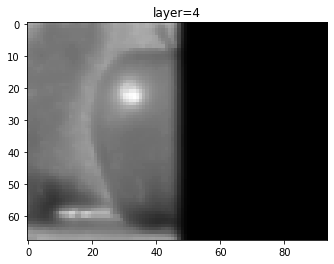

136 135


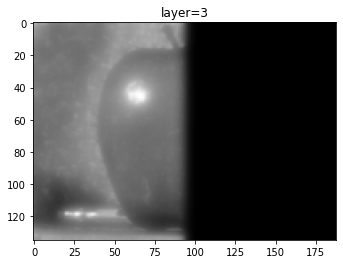

270 270


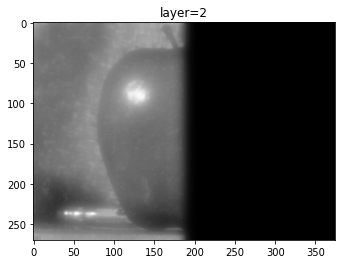

540 540


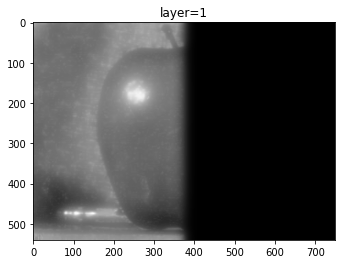

In [23]:
img0_reconstruct_pyr = reconstruct(img0_blended_pyr)

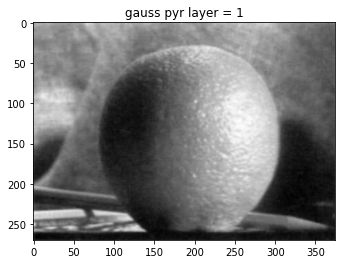

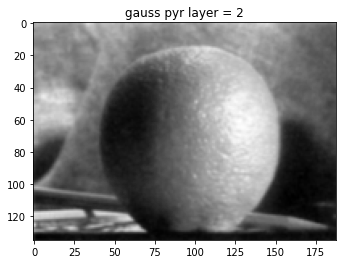

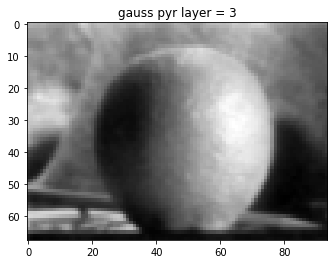

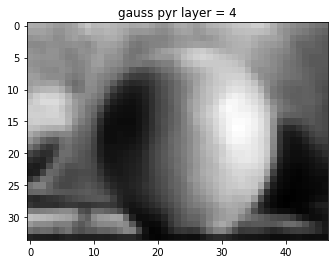

In [24]:
# 对橘子做一遍：
img1_gauss_pyr = gauss_pyramid(img1_gray,level)

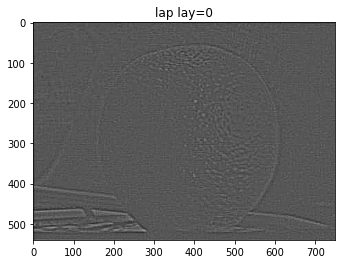

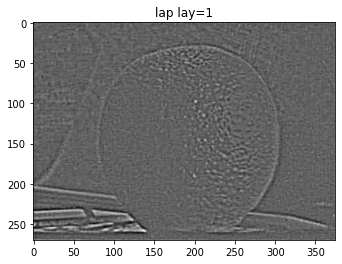

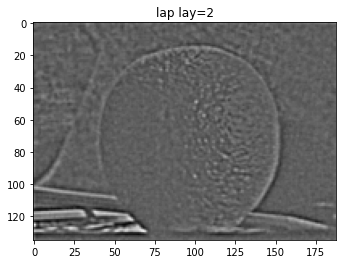

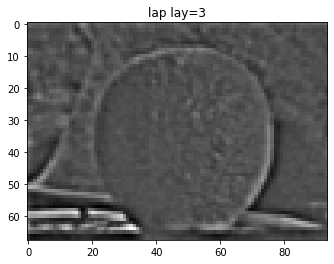

In [25]:
# lap pyr
img1_lap_pyr = lap_pyramid(img1_gauss_pyr,level)

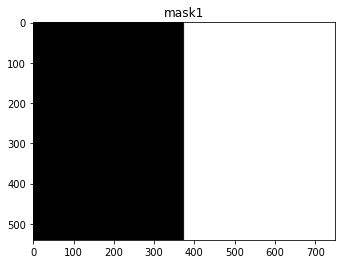

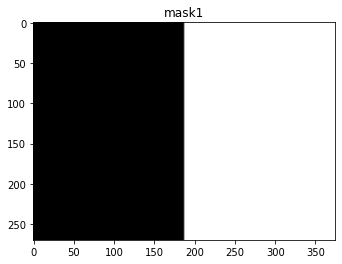

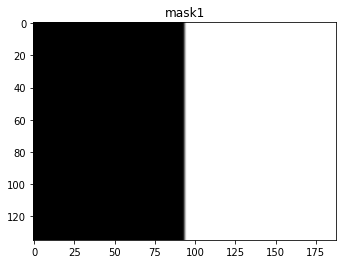

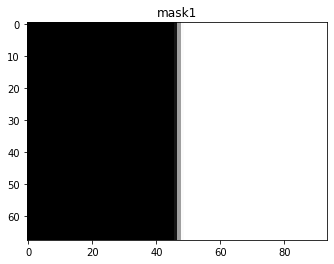

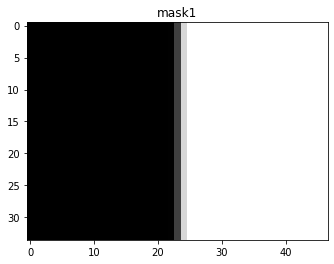

In [26]:
# create mask1 for img1
mask1_gauss = []
for i in range(len(mask0_gauss)):
    mask1_gauss.append(np.ones((mask0_gauss[i].shape))-mask0_gauss[i])
    plt_show("mask1",mask1_gauss[i],cmap="gray")

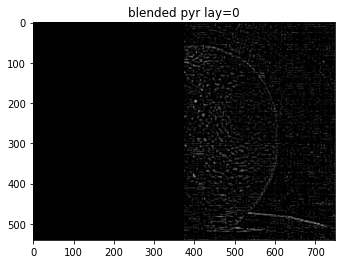

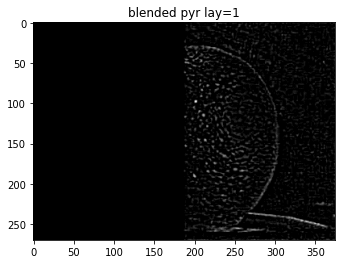

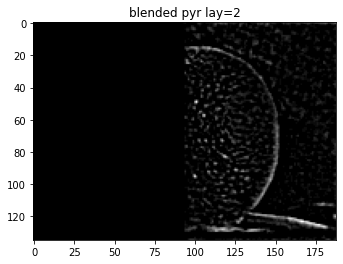

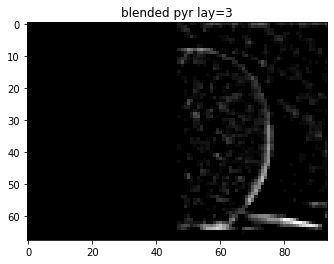

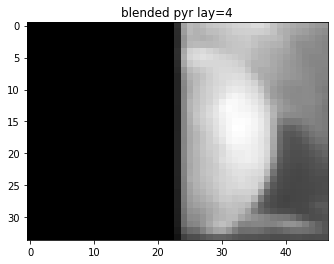

In [27]:
# blended:
img1_blended_pyr = blended_pyramid(img1_lap_pyr,mask1_gauss)

68 68


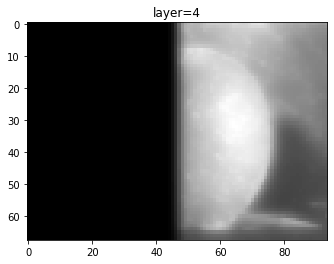

136 135


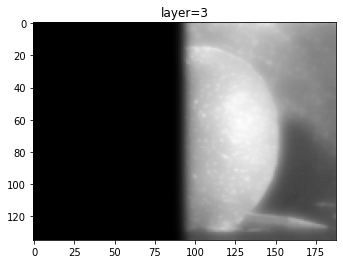

270 270


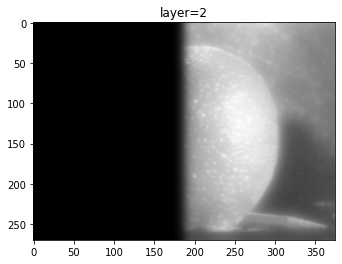

540 540


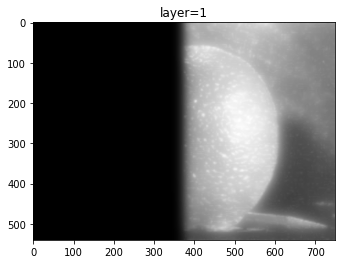

In [28]:
# reconstruct:
img1_reconstruct_pyr = reconstruct(img1_blended_pyr)

In [29]:
# 将苹果图像和橘子图像相融合：
def merge(img0_re,img1_re):
    merge = []
    for i in range(len(img0_re)):
        width = min(img0_re[i].shape[0],img1_re[i].shape[0])
        length = min(img0_re[i].shape[1],img1_re[i].shape[1])
        # a = np.array(img0_re[i][:width,:length],dtype='int')
        # b = np.array(img1_re[i][:width,:length],dtype='int')
        # add = int2uint(a+b)
        # print(img0_re[i].shape[1]//2)
        # add = np.hstack((img0_re[i][:,0:img0_re[i].shape[1]//2],img1_re[i][:,img0_re[i].shape[1]//2:]))
        a = img0_re[i][:width,:length]
        b = img1_re[i][:width,:length]
        add = int2uint(a+b)
        merge.append(add)

        # show:
        plt_show("merge layer={}".format(i),add,cmap="gray")
    return merge

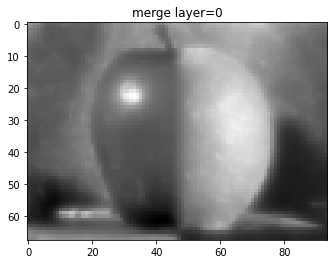

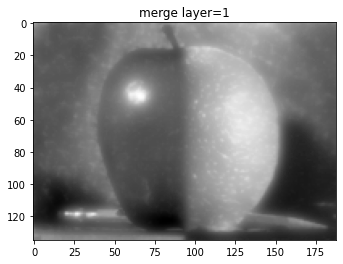

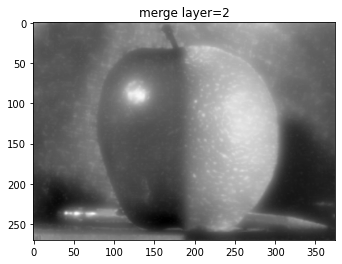

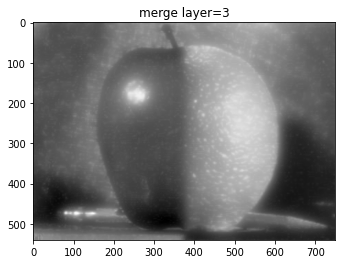

In [30]:
merge_img = merge(img0_reconstruct_pyr,img1_reconstruct_pyr)

In [31]:
# 更改顺序：先是两张图片先融合再重构金字塔：
def blended_pyramid_pro(img0_lap_pyr,img1_lap_pyr,mask0_gauss,mask1_gauss,level):
    blended_pyramid = []

    for i in range(level):
        # fix size
        height0 = min(img0_lap_pyr[i].shape[0],mask0_gauss[i].shape[0])
        length0 = min(img0_lap_pyr[i].shape[1],mask0_gauss[i].shape[1])
        height1 = min(img1_lap_pyr[i].shape[0],mask1_gauss[i].shape[0])
        length1 = min(img1_lap_pyr[i].shape[1],mask1_gauss[i].shape[1])
        blended_res = int2uint(np.multiply(img0_lap_pyr[i][:height0,:length0],mask0_gauss[i][:height0,:length0])+np.multiply(img1_lap_pyr[i][:height1,:length1],mask1_gauss[i][:height1,:length1]))
        blended_pyramid.append(blended_res)
    low_pass =  int2uint(np.multiply(img0_lap_pyr[level],mask0_gauss[level])+np.multiply(img1_lap_pyr[level],mask1_gauss[level]))
    blended_pyramid.append(low_pass)

    return blended_pyramid 

In [32]:
blended_pyr = blended_pyramid_pro(img0_lap_pyr,img1_lap_pyr,mask0_gauss,mask1_gauss,level)

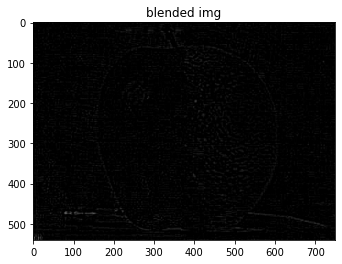

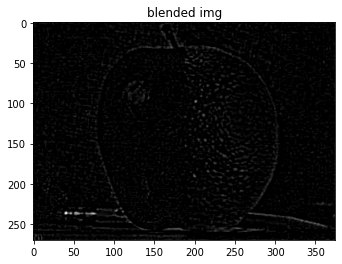

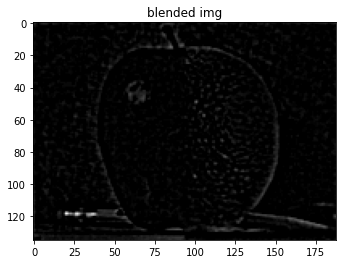

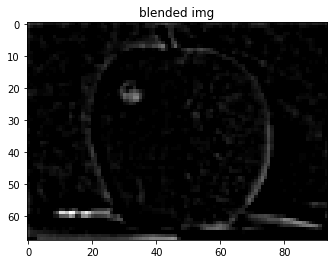

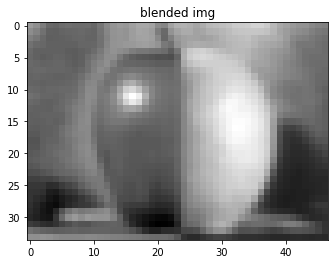

In [33]:
for i in range(level+1):
    plt_show("blended img",blended_pyr[i],cmap="gray")

68 68


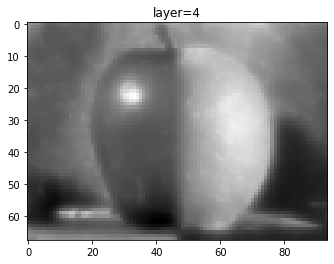

136 135


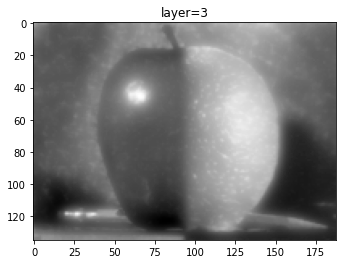

270 270


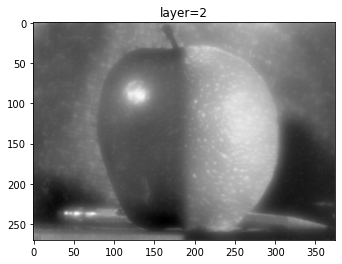

540 540


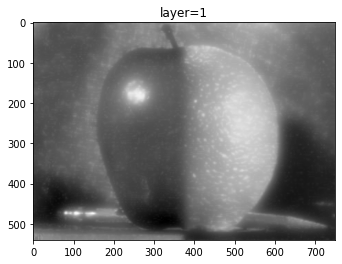

In [34]:
# 重构金字塔：
reconstruct_pyr_pro = reconstruct(blended_pyr)

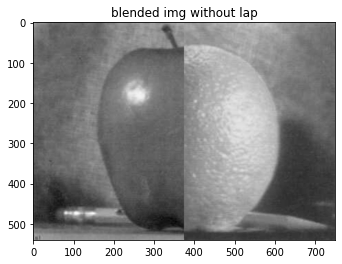

In [35]:
# compare:与生硬融合相对比：
add = int2uint(np.multiply(mask0,img0_gray)+ np.multiply((np.ones(mask0.shape)-mask0),img1_gray))
plt_show("blended img without lap",add,cmap="gray")

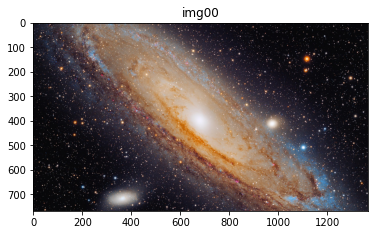

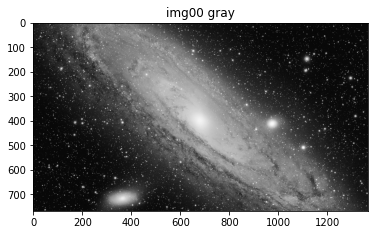

In [36]:
# 试一下三个的：
# load img:
img00 = cv2.imread('galaxy3.jpg')
# show:
img00_gray = cv2.cvtColor(img00,cv2.COLOR_BGR2GRAY)
img00_color = cv2.cvtColor(img00,cv2.COLOR_BGR2RGB)
plt_show("img00",img00_color)
plt_show("img00 gray",img00_gray,cmap="gray")

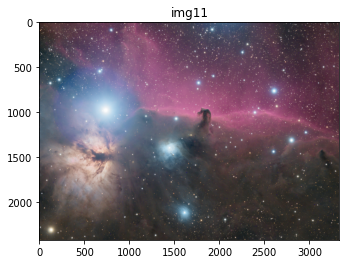

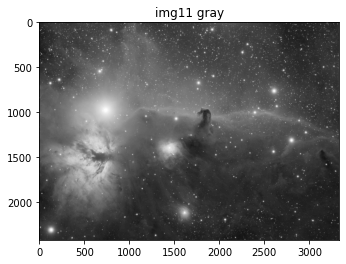

In [37]:
# 试一下三个的：
# load img:
img11 = cv2.imread('galaxy2.jpg')
# show:
img11_gray = cv2.cvtColor(img11,cv2.COLOR_BGR2GRAY)
img11_color = cv2.cvtColor(img11,cv2.COLOR_BGR2RGB)
plt_show("img11",img11_color)
plt_show("img11 gray",img11_gray,cmap="gray")

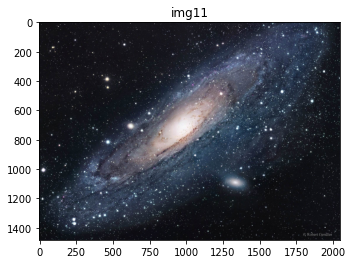

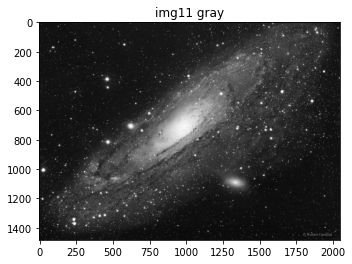

In [38]:
# 试一下三个的：
# load img:
img22 = cv2.imread('galaxy1.jpg')
# show:
img22_gray = cv2.cvtColor(img22,cv2.COLOR_BGR2GRAY)
img22_color = cv2.cvtColor(img22,cv2.COLOR_BGR2RGB)
plt_show("img11",img22_color)
plt_show("img11 gray",img22_gray,cmap="gray")

In [39]:
# fix size: 三张图片尺寸对齐：
width = np.min((img00_gray.shape[0],img11_gray.shape[0],img22_gray.shape[0]))
length= np.min((img00_gray.shape[1],img11_gray.shape[1],img22_gray.shape[1]))
img00 = img00[:width,:length]
img11 = img11[:width,:length]
img22 = img22[:width,:length]
img00_gray = img00_gray[:width,:length]
img11_gray = img11_gray[300:300+width,300:300+length]
img22_gray = img22_gray[:width,:length]
print(width,length)

768 1366


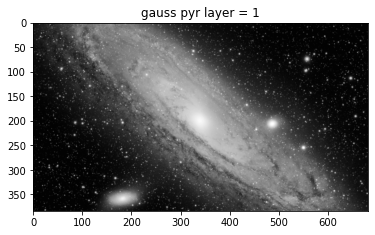

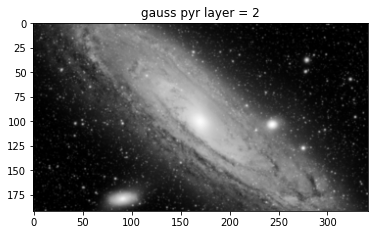

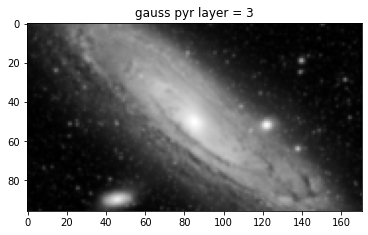

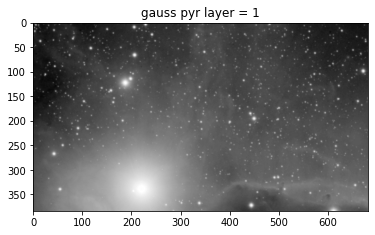

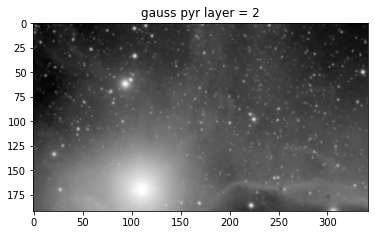

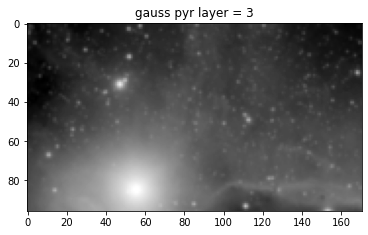

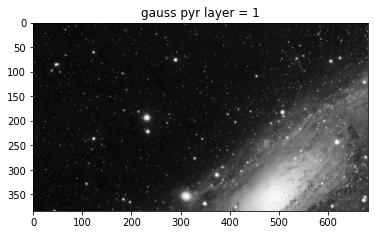

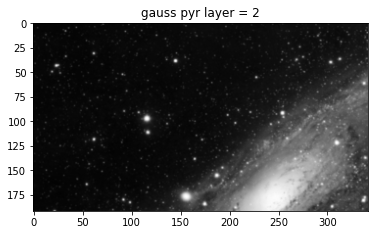

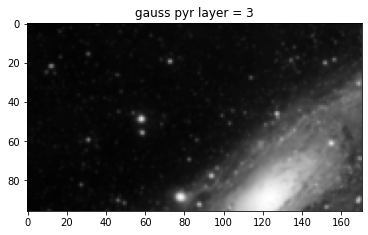

In [40]:
# 先对三者进行高斯：
img00_gauss_pyr = gauss_pyramid(img00_gray,3)
img11_gauss_pyr = gauss_pyramid(img11_gray,3)
img22_gauss_pyr = gauss_pyramid(img22_gray,3)

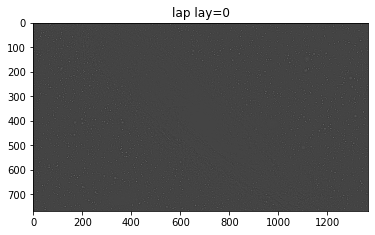

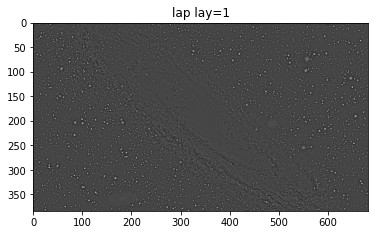

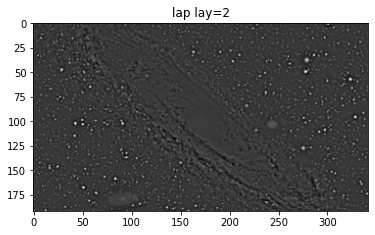

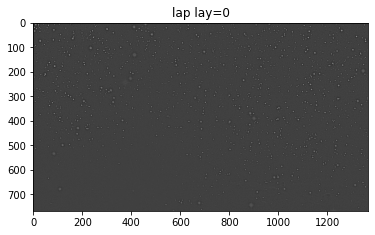

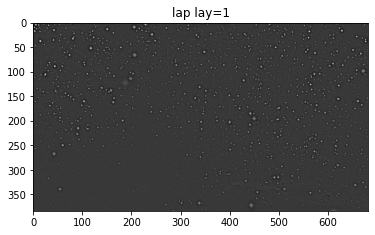

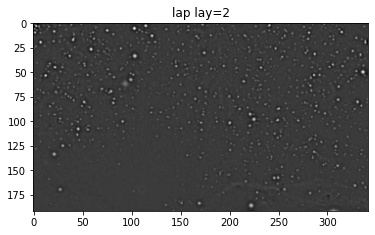

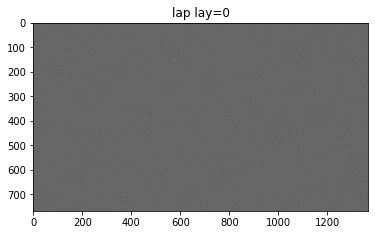

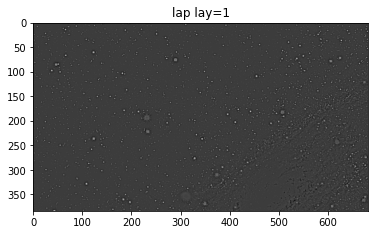

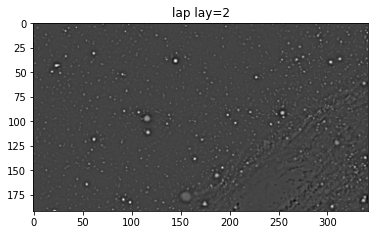

In [41]:
# 做拉普拉斯
img00_lap_pyr = lap_pyramid(img00_gauss_pyr,3)
img11_lap_pyr = lap_pyramid(img11_gauss_pyr,3)
img22_lap_pyr = lap_pyramid(img22_gauss_pyr,3)


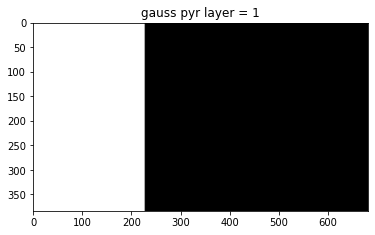

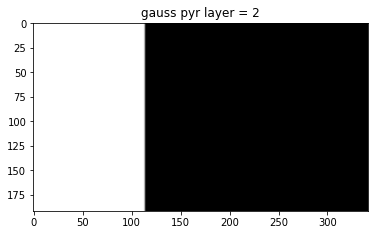

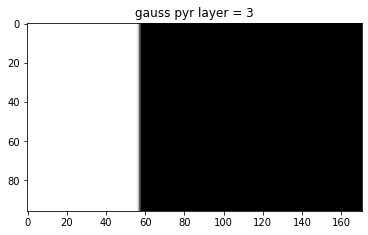

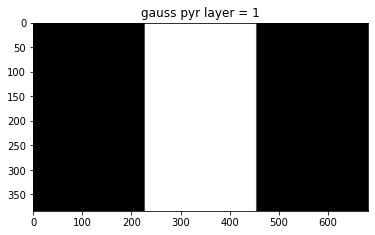

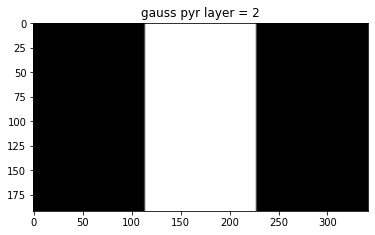

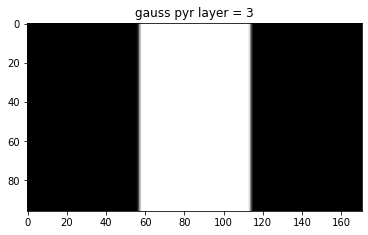

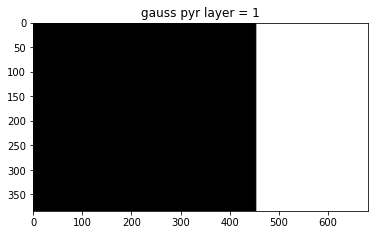

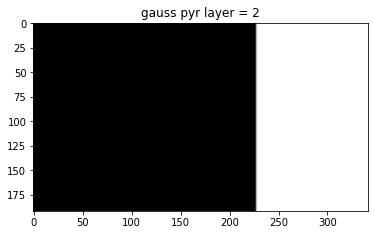

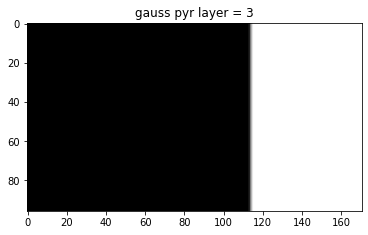

In [42]:
# mask:
mask00 = np.zeros((img00.shape[:2]))
mask00[:,:img00.shape[1]//3] = 1
mask00_gauss = gauss_pyramid(mask00,3)
# mask:
mask11 = np.zeros((img00.shape[:2]))
mask11[:,img00.shape[1]//3:img00.shape[1]//3*2] = 1
mask11_gauss = gauss_pyramid(mask11,3)
# mask:
mask22 = np.zeros((img00.shape[:2]))
mask22[:,img00.shape[1]//3*2:] = 1
mask22_gauss = gauss_pyramid(mask22,3)

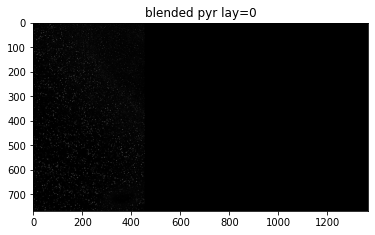

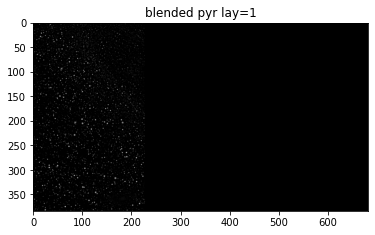

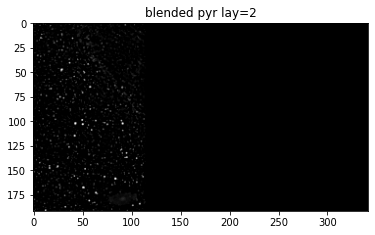

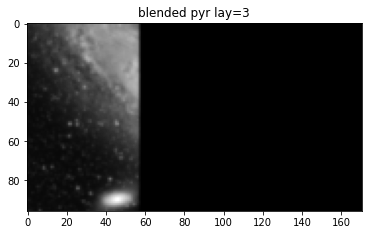

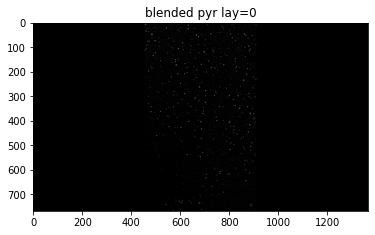

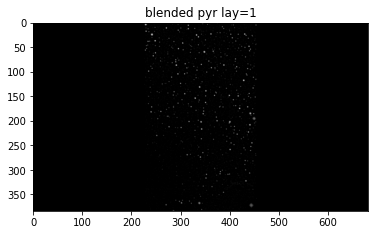

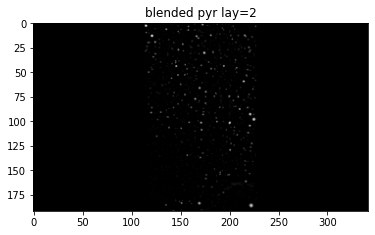

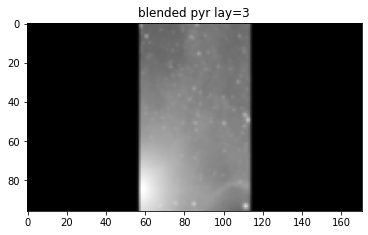

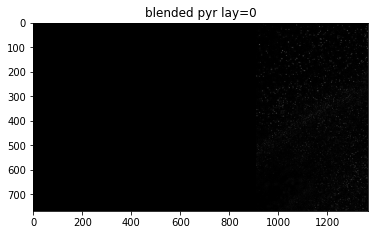

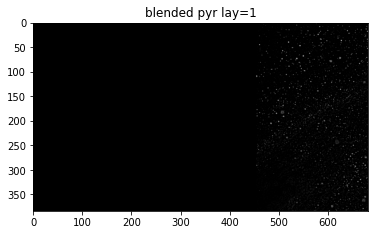

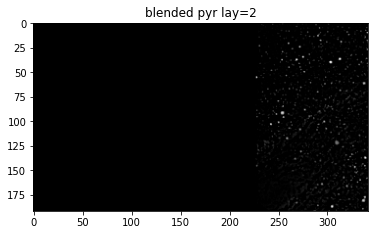

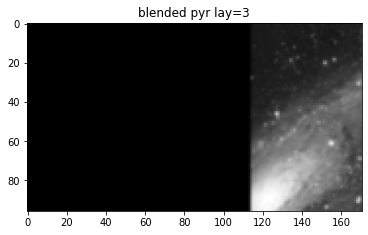

In [43]:
# 混合：
img00_blended_pyr = blended_pyramid(img00_lap_pyr,mask00_gauss)
img11_blended_pyr = blended_pyramid(img11_lap_pyr,mask11_gauss)
img22_blended_pyr = blended_pyramid(img22_lap_pyr,mask22_gauss)

192 192


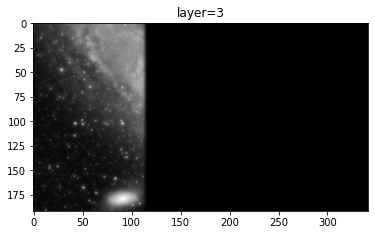

384 384


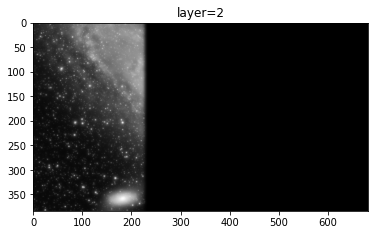

768 768


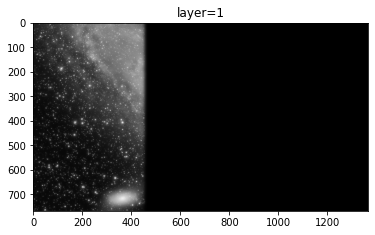

192 192


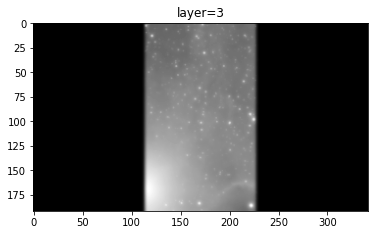

384 384


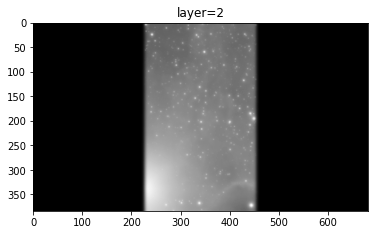

768 768


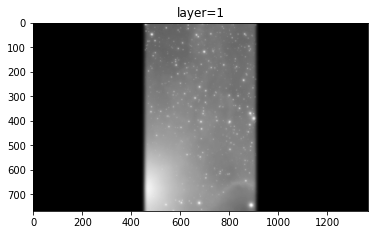

192 192


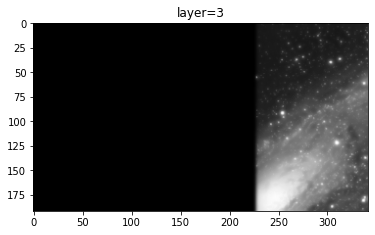

384 384


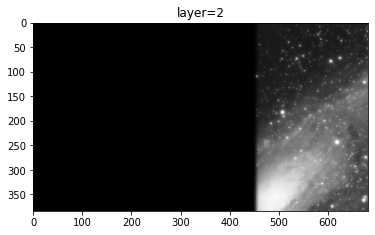

768 768


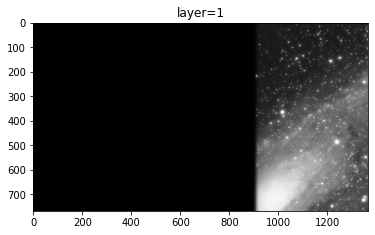

In [44]:
# reconstruct:
img00_re_pyr = reconstruct(img00_blended_pyr)
img11_re_pyr = reconstruct(img11_blended_pyr)
img22_re_pyr = reconstruct(img22_blended_pyr)


In [45]:
# merge:
def merge4three(img0_re,img1_re,img2_re):
    merge = []
    for i in range(len(img0_re)):
        width = min(img0_re[i].shape[0],img1_re[i].shape[0],img2_re[i].shape[0])
        length = min(img0_re[i].shape[1],img1_re[i].shape[1],img2_re[i].shape[1])

        a = img0_re[i][:width,:length]
        b = img1_re[i][:width,:length]
        c = img2_re[i][:width,:length]
        add = int2uint(a+b+c)
        merge.append(add)

        # show:
        plt_show("merge layer={}".format(i),add,cmap="gray")
    return merge

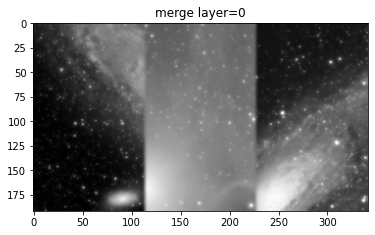

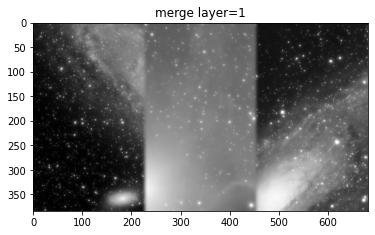

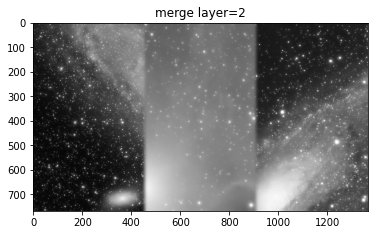

In [46]:
three_merge = merge4three(img00_re_pyr,img11_re_pyr,img22_re_pyr)

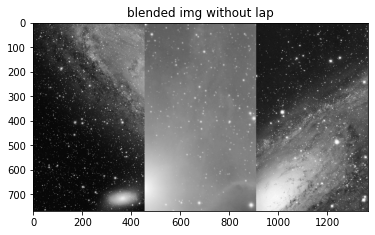

In [47]:
# compare: 与直接生硬融合相比较：
add_c = int2uint(np.multiply(mask00,img00_gray)+ np.multiply(mask11,img11_gray)+np.multiply(mask22,img22_gray))
plt_show("blended img without lap",add_c,cmap="gray")
